In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [5]:
presentation_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna',]

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

presentation_analysis.rename(columns={'language_accessibility': 'language_accessibility_presentation'}, inplace=True)
qna_analysis.rename(columns={'language_accessibility': 'language_accessibility_qna'}, inplace=True)

qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(presentation_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

for emotion in emotions:
    llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
    llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
    scaler = MinMaxScaler()
    llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,fear_analysts,joy_analysts,nervousness_analysts,optimism_analysts,pride_analysts,realization_analysts,relief_analysts,remorse_analysts,sadness_analysts,surprise_analysts
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.000000,0.0,0.966905,0.0,0.145973,0.0,0.0,0.0,0.457073
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.151184,0.0,0.000000,0.0,0.0,0.0,0.000000
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.000000,0.642977,0.0,0.082452,0.0,0.030370,0.0,0.0,0.0,0.607991
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.313183,0.000000,0.0,0.230339,0.0,0.164301,0.0,0.0,0.0,0.118028
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.000000,0.000000,0.0,0.212880,0.0,0.062939,0.0,0.0,0.0,0.000000


In [16]:
# PCA for emotions
from sklearn.decomposition import PCA

# Apply PCA for the presentation emotions
pca_presentation = PCA(n_components=5)  # Retain 95% variance
presentation_pca = pca_presentation.fit_transform(llm_output[emotions])

# Apply PCA for the Q&A emotions
pca_qna = PCA(n_components=5)
qna_pca = pca_qna.fit_transform(llm_output[qna_labels])

# Apply PCA for the analyst emotions
pca_analyst = PCA(n_components=5)
analyst_pca = pca_analyst.fit_transform(llm_output[analyst_emotions])

# Add the PCA components back to the dataframe
for i in range(presentation_pca.shape[1]):
    llm_output[f'presentation_pca_{i}'] = presentation_pca[:, i]

for i in range(qna_pca.shape[1]):
    llm_output[f'qna_pca_{i}'] = qna_pca[:, i]

for i in range(analyst_pca.shape[1]):
    llm_output[f'analyst_pca_{i}'] = analyst_pca[:, i]

In [17]:
# The components are stored in the `components_` attribute
loadings_presentation = pca_presentation.components_

# Create a DataFrame for the loadings
loadings_df_presentation = pd.DataFrame(
    loadings_presentation.T,  # Transpose so that each column corresponds to a PC
    index=emotions,  # The original feature names
    columns=[f'PC{i+1}' for i in range(loadings_presentation.shape[0])]
)

# Display the loadings DataFrame
loadings_df_presentation

,PC1,PC2,PC3,PC4,PC5
admiration,0.326600,-0.136562,-0.225878,-0.349448,0.258366
anger,0.384848,-0.194083,-0.031980,0.279419,-0.351407
annoyance,0.248430,-0.086643,-0.261817,-0.293448,-0.217005
approval,-0.131938,0.035489,0.130374,-0.129329,-0.017762
caring,0.308082,-0.129771,0.135165,0.554815,0.003945
confusion,-0.140408,0.113949,-0.007650,0.184418,0.096815
curiosity,0.010003,0.802606,-0.042745,0.120018,-0.272841
desire,0.195198,0.091549,0.097624,-0.165939,0.031020
disappointment,0.399464,0.376483,-0.279004,0.013273,0.079572
disapproval,0.081653,0.092102,-0.261853,0.179278,0.265419


In [20]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [29]:
'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = llm_output[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    #+ presentation_labels 
                    #+ qna_labels
                    #+ emotions
                    #+ analyst_emotions
                    #+ [f'presentation_pca_{i}' for i in range(5)]
                    #+ [f'qna_pca_{i}' for i in range(5)]
                    + [f'analyst_pca_{i}' for i in range(5)]
                    ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     39.61
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           2.41e-37
Time:                        15:01:29   Log-Likelihood:                -4817.0
No. Observations:                1051   AIC:                             9646.
Df Residuals:                    1045   BIC:                             9676.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.7025      0.732     47.379

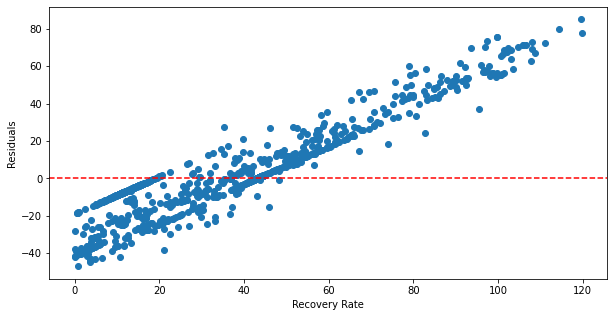

In [30]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()